In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

In [4]:
def readText(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [5]:
captions = readText(".\Flickr_TextData\Flickr8k.token.txt")
print(type(captions))

<class 'str'>


In [6]:
## Length of the Caption text Data
#last caption empty hence remove
captions = captions.split("\n")[:-1]
print(len(captions))

40460


In [7]:
print(captions[0])
print(captions[-1])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .


In [8]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [9]:
## We can read this file as follows : 
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Get images

In [10]:
import cv2

In [11]:
img = cv2.imread(r".\Images\1000268201_693b08cb0e.jpg")


<function matplotlib.pyplot.show(close=None, block=None)>

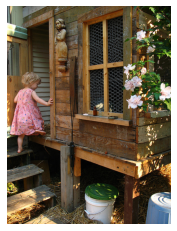

In [12]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show

# Data cleaning

In [13]:
def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [14]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [15]:
descriptions['1000268201_693b08cb0e'] # Check for an image 

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

# data preprocess file

In [16]:
# Write the data to text file

with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

In [17]:
#  reading description file

f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

# Creating Vocabulary

In [18]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [19]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [20]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]
len(all_vocab)

1845

In [21]:
print(len(all_vocab)) # Show Sorted >freq uniqe words

1845


# test/ train data

In [22]:
train_file_data = readText("Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readText("Flickr_TextData/Flickr_8k.testImages.txt")

In [23]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]


In [24]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [25]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [26]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Image Preprocessing

In [27]:
IMG_PATH = ".\Images"

In [28]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3)) 
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [29]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [30]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [31]:
import keras.utils as image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


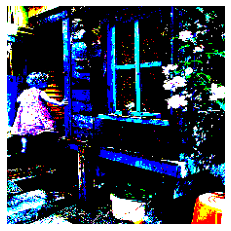

In [32]:
img = preprocess_image("Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

# Data Preprocessing for image encoding 

In [33]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [34]:
encode_image("Images/1000268201_693b08cb0e.jpg")

1/1 [==============================] - 3s 3s/step


array([0.0653655 , 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817933,
       1.0043333 ], dtype=float32)

In [35]:
start = time()

from tqdm.notebook import tqdm

encoding_train = {}

for ix, img_id in tqdm(enumerate(train),total=len(train)):
     
    img = IMG_PATH+"/"+img_id+".jpg".format(train[ix])
    # encoding_train[img[len(images):]] = encode_image(img)
    encoding_train[img_id] = encode_image(img)
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 167ms/step
Encoding image- 0
1/1 [==============================] - 0s 158ms/step
Encoding image- 100
1/1 [==============================] - 0s 201ms/step
Encoding image- 200
1/1 [==============================] - 0s 309ms/step
Encoding image- 300
1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 236ms/step
Encoding image- 400
1/1 [==============================] - 0s 223ms/step
Encoding image- 500
1/1 [==============================] - 0s 239ms/step
Encoding image- 600
1/1 [==============================] - 0s 225ms/step


1/1 [==============================] - 0s 252ms/step
Encoding image- 700
1/1 [==============================] - 0s 263ms/step
Encoding image- 800
1/1 [==============================] - 0s 227ms/step
Encoding image- 900
1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 302ms/step
Encoding image- 1000
1/1 [==============================] - 0s 260ms/step
Encoding image- 1100
1/1 [==============================] - 0s 236ms/step
Encoding image- 1200
1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 246ms/step
Encoding image- 1300
1/1 [==============================] - 0s 261ms/step
Encoding image- 1400
1/1 [==============================] - 0s 238ms/step
Encoding image- 1500
1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 265ms/step
Encoding image- 1600
1/1 [==============================] - 0s 309ms/step
Encoding image- 1700
1/1 [==============================] - 0s 400ms/step
Encoding image- 1800
1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 318ms/step
Encoding image- 1900
1/1 [==============================] - 0s 337ms/step
Encoding image- 2000
1/1 [==============================] - 0s 212ms/step
Encoding image- 2100
1/1 [==============================] - 0s 220ms/step


1/1 [==============================] - 0s 230ms/step
Encoding image- 2200
1/1 [==============================] - 0s 241ms/step
Encoding image- 2300
1/1 [==============================] - 0s 274ms/step
Encoding image- 2400
1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 256ms/step
Encoding image- 2500
1/1 [==============================] - 0s 332ms/step
Encoding image- 2600
1/1 [==============================] - 0s 265ms/step
Encoding image- 2700
1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 248ms/step
Encoding image- 2800
1/1 [==============================] - 0s 308ms/step
Encoding image- 2900
1/1 [==============================] - 0s 341ms/step
Encoding image- 3000
1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 265ms/step
Encoding image- 3100
1/1 [==============================] - 0s 308ms/step
Encoding image- 3200
1/1 [==============================] - 0s 301ms/step
Encoding image- 3300
1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 307ms/step
Encoding image- 3400
1/1 [==============================] - 0s 290ms/step
Encoding image- 3500
1/1 [==============================] - 0s 375ms/step
Encoding image- 3600
1/1 [==============================] - 0s 428ms/step


1/1 [==============================] - 0s 343ms/step
Encoding image- 3700
1/1 [==============================] - 0s 440ms/step
Encoding image- 3800
1/1 [==============================] - 0s 402ms/step
Encoding image- 3900
1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 376ms/step
Encoding image- 4000
1/1 [==============================] - 0s 298ms/step
Encoding image- 4100
1/1 [==============================] - 0s 304ms/step
Encoding image- 4200
1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 321ms/step
Encoding image- 4300
1/1 [==============================] - 0s 391ms/step
Encoding image- 4400
1/1 [==============================] - 0s 361ms/step
Encoding image- 4500
1/1 [==============================] - 0s 292ms/step
Encoding image- 4600
1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 433ms/step
Encoding image- 4700
1/1 [==============================] - 0s 335ms/step
Encoding image- 4800
1/1 [==============================] - 0s 445ms/step
Encoding image- 4900
1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 321ms/step
Encoding image- 5000
1/1 [==============================] - 0s 361ms/step
Encoding image- 5100
1/1 [==============================] - 0s 392ms/step
Encoding image- 5200
1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 301ms/step
Encoding image- 5300
1/1 [==============================] - 0s 421ms/step
Encoding image- 5400
1/1 [==============================] - 0s 419ms/step
Encoding image- 5500
1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 1s 572ms/step
Encoding image- 5600
1/1 [==============================] - 0s 436ms/step
Encoding image- 5700
1/1 [==============================] - 0s 318ms/step
Encoding image- 5800
1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 1s 516ms/step
Encoding image- 5900
1/1 [==============================] - 0s 491ms/step
Time taken in seconds = 2934.753038406372


In [36]:
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [37]:

start = time()

encoding_test = {}

for ix, img_id in tqdm(enumerate(test),total=len(test)):
            
    img = IMG_PATH+"/"+img_id+".jpg".format(test[ix])
    # encoding_test[img[len(images):]] = encode_image(img)
    encoding_test[img_id] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 474ms/step
Encoding image- 0
1/1 [==============================] - 0s 494ms/step
Encoding image- 100
1/1 [==============================] - 1s 520ms/step
Encoding image- 200
1/1 [==============================] - 1s 569ms/step
Encoding image- 300
1/1 [==============================] - 1s 558ms/step


1/1 [==============================] - 1s 728ms/step
Encoding image- 400
1/1 [==============================] - 1s 902ms/step
Encoding image- 500
1/1 [==============================] - 1s 594ms/step
Encoding image- 600
1/1 [==============================] - 1s 692ms/step


1/1 [==============================] - 1s 581ms/step
Encoding image- 700
1/1 [==============================] - 1s 565ms/step
Encoding image- 800
1/1 [==============================] - 1s 698ms/step
Encoding image- 900
1/1 [==============================] - 1s 999ms/step


1/1 [==============================] - 1s 938ms/step
Time taken in seconds = 771.6167151927948


In [38]:
# Save the bottleneck train features to disk

with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [39]:
# Load the train images features from disk

with open("./encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

# Data preprocessing for captions

In [40]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [41]:
word_to_idx["dog"]

6

In [42]:
print(len(idx_to_word))

1845


In [43]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [67]:
with open("word_to_idx.pkl","wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("idx_to_word.pkl","wb") as i2w:
    pickle.dump(idx_to_word, i2w)

In [44]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [45]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


# Data loader

In [46]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1
          
            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = [], [], []
                n=0

# Word Embeddings

In [47]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
f = open("glove.6B.50d.txt", encoding = 'utf8')

In [49]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [50]:
f.close()

In [51]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

# Converting words into vector

In [52]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [53]:
embedding_output.shape

(1848, 50)

## Model Architechure

In [54]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [55]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [56]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add

In [57]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [58]:
model.summary() # Basicallly Show How my Lyers are connected

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [59]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [60]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

## Traning 

In [61]:
epochs = 15
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [62]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

C:\Users\pvash\AppData\Local\Temp/ipykernel_17668/2804007631.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 1629s 814ms/step - loss: 2.6465


# Predictions 

In [63]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

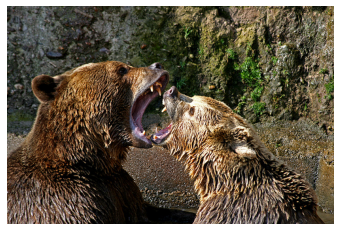

1/1 [==============================] - 0s 46ms/step
two dogs are standing on rock with trees in the background


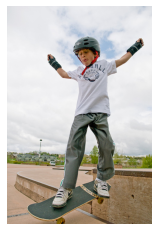

1/1 [==============================] - 0s 36ms/step
boy in blue shirt and helmet is jumping on the street


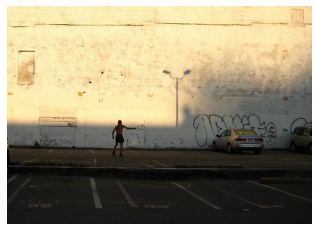

1/1 [==============================] - 0s 32ms/step
man is riding motorcycle on the street


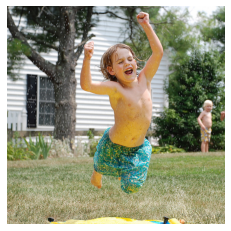

1/1 [==============================] - 0s 29ms/step
young boy in red shirt is jumping on the grass


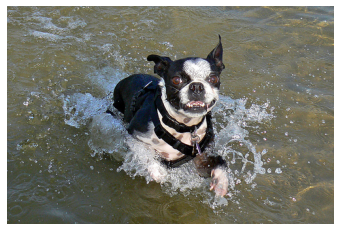

1/1 [==============================] - 0s 49ms/step
black and white dog is swimming in water


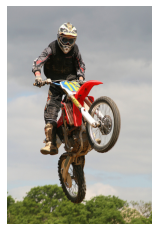

1/1 [==============================] - 0s 37ms/step
man in red helmet is riding bike on dirt trail


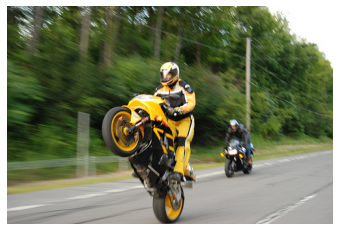

1/1 [==============================] - 0s 49ms/step
man rides his bike on the track


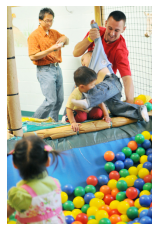

1/1 [==============================] - 0s 37ms/step
boy in red shirt is standing in front of an ice slide


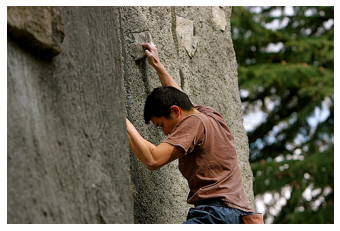

1/1 [==============================] - 0s 43ms/step
man in red shirt is rock climbing


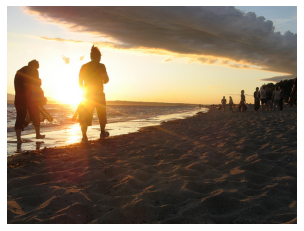

1/1 [==============================] - 0s 41ms/step
man in yellow is standing on top of mountain looking at the view


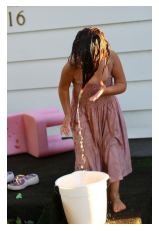

1/1 [==============================] - 0s 42ms/step
man in black shirt and cast hat sits on the street


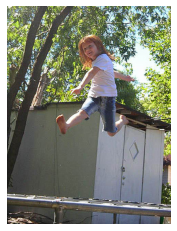

1/1 [==============================] - 0s 40ms/step
man in blue shirt is climbing up fence


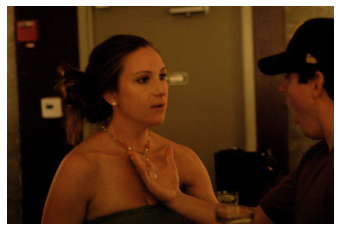

1/1 [==============================] - 0s 29ms/step
man with glasses and beard posing for the camera


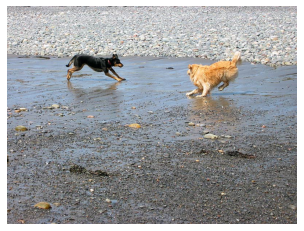

1/1 [==============================] - 0s 28ms/step
two dogs play in the water


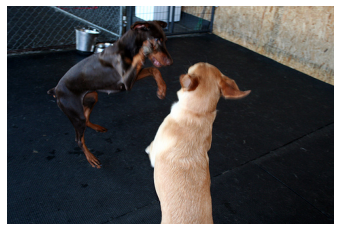

1/1 [==============================] - 0s 33ms/step
two dogs are playing with each other on the grass


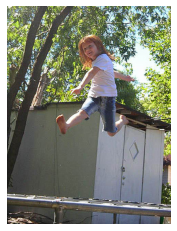

1/1 [==============================] - 0s 37ms/step
man in blue shirt is climbing up fence


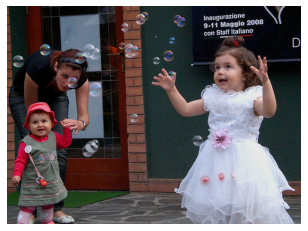

1/1 [==============================] - 0s 50ms/step
two men in red dresses are standing in front of flower building


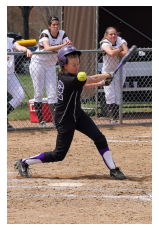

1/1 [==============================] - 0s 34ms/step
boy in red shirt is playing baseball


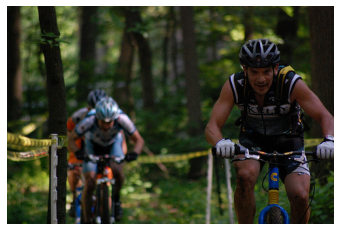

1/1 [==============================] - 0s 32ms/step
man on bike is riding on dirt track


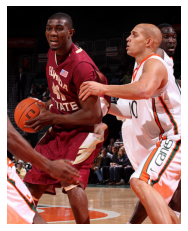

1/1 [==============================] - 0s 31ms/step
basketball player dribbles the ball


In [66]:
for i in range(20):
    rn =  np.random.randint(0, 1000)

    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH +"/" +img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)